In [1]:
import pickle
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt
import shap
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# Specify the path to the pickle file 
file_path = "../datasets/nanoparticle/nanoparticle.pickle"
# Load the content from the pickle file
with open(file_path, "rb") as file:
    data_df = pickle.load(file)

# Combine datadrames with same features together 
pt_data_df = data_df[-1]
gold_data_df = data_df[0]
silver_data_df = data_df[1]
X_df = pd.concat([pt_data_df, gold_data_df, silver_data_df], axis=0)
X_df = X_df.reset_index(drop=True)

# X_df = gold_data_df
# first 42 columns are features, last 1 column is target
X = X_df.iloc[:, :53]
y = X_df.iloc[:, -1]

# Combine them into a new DataFrame
X_df = pd.concat([X, y], axis=1)
X_df.describe()

,T,tau,time,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,...,angle_avg,angle_std,FCC,HCP,ICOS,DECA,q6q6_avg_total,q6q6_avg_bulk,q6q6_avg_surf,DBoxEX
count,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9.300000e+03,9300.000000,9300.000000,9300.000000,...,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000
mean,606.333333,0.000058,8.112903,3581.136129,2602.197204,978.938925,5.554742e-26,15.648161,25.750581,10.102420,...,96.047797,34.716732,1404.724839,283.678172,0.060215,11.096989,8.369649,9.683653,5.909430,2.309753
std,215.349938,0.000082,2.896788,3860.060442,3124.428218,758.647200,5.980015e-26,6.379869,9.979958,6.680642,...,0.637237,0.386454,2020.848194,565.981711,0.267676,25.623819,3.299092,3.748338,2.473576,0.030870
min,273.000000,0.000000,1.000000,137.000000,45.000000,92.000000,2.010000e-27,0.519100,8.591600,1.782200,...,92.938500,33.545186,0.000000,0.000000,0.000000,0.000000,0.261500,0.263700,0.221600,2.134578
25%,423.000000,0.000000,6.000000,1054.000000,616.000000,432.000000,1.620000e-26,11.401125,18.119400,5.113300,...,95.686775,34.504063,150.000000,0.000000,0.000000,0.000000,8.258375,10.053525,5.034425,2.292831
50%,623.000000,0.000000,10.000000,1896.000000,1217.000000,666.000000,2.910000e-26,14.341800,22.630300,7.554550,...,96.142750,34.751582,589.500000,38.000000,0.000000,0.000000,9.751650,11.440700,6.680100,2.308198
75%,723.000000,0.000125,10.000000,4605.000000,3281.000000,1353.250000,7.270000e-26,17.879850,33.896975,13.278800,...,96.513400,34.997497,1558.000000,250.000000,0.000000,10.000000,10.437775,11.961350,7.828325,2.324235
max,973.000000,0.000250,10.000000,16262.000000,13423.000000,3200.000000,2.420000e-25,35.136500,66.680000,44.270600,...,97.283400,35.617392,11163.000000,4558.000000,3.000000,257.000000,11.403900,12.239700,8.833300,2.488645


In [3]:
def scale_importance(feature_importance_df, feature_col='feature', importance_col='importance'):
    # Initialize a MinMaxScaler
    scaler = MinMaxScaler()

    # Scale the importance values
    scaled_importance = scaler.fit_transform(feature_importance_df[[importance_col]])

    # Create a new DataFrame with the scaled importance
    scaled_feature_importance_df = feature_importance_df.copy()
    scaled_feature_importance_df[importance_col] = scaled_importance

    return scaled_feature_importance_df

In [4]:
# set feature sets by feature names
X_df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X_df), columns=X_df.columns)
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]

X_df.describe()


,T,tau,time,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,...,angle_avg,angle_std,FCC,HCP,ICOS,DECA,q6q6_avg_total,q6q6_avg_bulk,q6q6_avg_surf,DBoxEX
count,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9.300000e+03,9300.000000,9300.000000,9300.000000,...,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000
mean,0.476190,0.230645,0.790323,0.213590,0.191149,0.285373,5.353742e-26,0.437036,0.295394,0.195823,...,0.715620,0.565362,0.125838,0.062237,0.020072,0.043179,0.727684,0.786569,0.660477,0.494750
std,0.307643,0.329038,0.321865,0.239384,0.233550,0.244095,5.980015e-26,0.184297,0.171806,0.157234,...,0.146663,0.186494,0.181031,0.124173,0.089225,0.099704,0.296084,0.312988,0.287234,0.087186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.214286,0.000000,0.555556,0.056868,0.042682,0.109395,1.419000e-26,0.314351,0.164022,0.078400,...,0.632529,0.462733,0.013437,0.000000,0.000000,0.000000,0.717698,0.817454,0.558870,0.446956
50%,0.500000,0.000000,1.000000,0.109085,0.087607,0.184685,2.709000e-26,0.399299,0.241678,0.135857,...,0.737474,0.582180,0.052808,0.008337,0.000000,0.000000,0.851715,0.933283,0.749968,0.490359
75%,0.642857,0.500000,1.000000,0.277085,0.241890,0.405808,7.069000e-26,0.501504,0.435636,0.270582,...,0.822781,0.700853,0.139568,0.054849,0.000000,0.038911,0.913293,0.976758,0.883301,0.535653
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.399900e-25,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df.iloc[:, :-1], X_df.iloc[:, -1], test_size=0.2, random_state=42)

## Explanations from equally-good models

In [13]:
# Train test split and train a random forest model
# max_depth: 30, max_features: 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 350
rf = RandomForestRegressor(max_depth=30, max_features=30, min_samples_leaf=5, min_samples_split=5, n_estimators=350)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("R2 score: {}".format(r2_score(y_train, rf.predict(X_train))))
print("MAE: {}".format(mean_absolute_error(y_train, rf.predict(X_train))))
print("R2 score: {}".format(r2_score(y_test, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))


R2 score: 0.89886727800388
MAE: 0.01921308607660999
R2 score: 0.750841660242381
MAE: 0.03176890675414628


In [6]:
# trian a xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, learning_rate=0.02, max_depth=5, n_estimators=350, gamma=0, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("R2 score: {}".format(r2_score(y_train, xgb_model.predict(X_train))))
print("MAE: {}".format(mean_absolute_error(y_train, xgb_model.predict(X_train))))
print("R2 score: {}".format(r2_score(y_test, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.8257746038530336
MAE: 0.02744678000472676
R2 score: 0.7436599782707676
MAE: 0.03204905176443973


In [12]:
# train a MLP from sklearn
mlp = MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64), max_iter=1000, activation='relu', learning_rate_init=0.005, random_state=42, early_stopping=True, solver='adam', alpha=0.0001, learning_rate='constant')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("R2 score: {}".format(r2_score(y_train, mlp.predict(X_train))))
print("MAE: {}".format(mean_absolute_error(y_train, mlp.predict(X_train))))
print("R2 score: {}".format(r2_score(y_test, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

R2 score: 0.7507074840923165
MAE: 0.03172647267324614
R2 score: 0.7437985226519476
MAE: 0.03255797879655191


In [10]:
# apply shap to the above models
# Sample a subset of the training data
X_train_summary = shap.sample(X_train, 100)  # adjust the number of samples as needed

# Create a SHAP explainer object
explainer = shap.KernelExplainer(mlp.predict, X_train_summary)

# Calculate SHAP values for the test set
shap_values_mlp = explainer(X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
100%|██████████| 1860/1860 [41:45<00:00,  1.35s/it]


<Axes: xlabel='feature'>

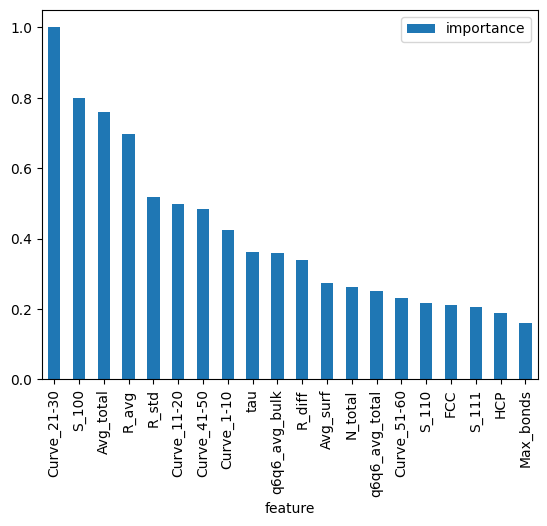

In [12]:
# get mean absolue shap values from shap values
feature_importance_shap_mlp = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(shap_values_mlp.values).mean(0)})
feature_importance_shap_mlp.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_shap = feature_importance_shap_mlp.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_shap).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

In [13]:
# Create a SHAP explainer object
explainer_rf = shap.KernelExplainer(rf.predict, X_train_summary)
# Calculate SHAP values for the test set.
shap_values_rf = explainer_rf(X_test)

100%|██████████| 1860/1860 [2:02:32<00:00,  3.95s/it] 


In [8]:
# Create a SHAP explainer object
explainer_xgboost = shap.Explainer(xgb_model)
# Calculate SHAP values for the test set
shap_values_xgboost = explainer_xgboost(X_test)

In [ ]:
# apply permutation to the above models
per_xgboost = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = per_xgboost.importances_mean.argsort()

In [14]:
per_mlp = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
per_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

<Axes: xlabel='feature'>

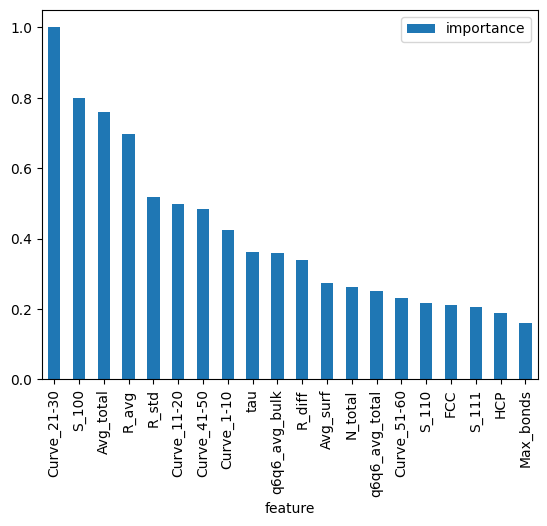

In [36]:
# get mean absolue shap values from shap values
feature_importance_shap_mlp = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(shap_values_mlp.values).mean(0)})
feature_importance_shap_mlp.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_shap = feature_importance_shap_mlp.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_shap).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

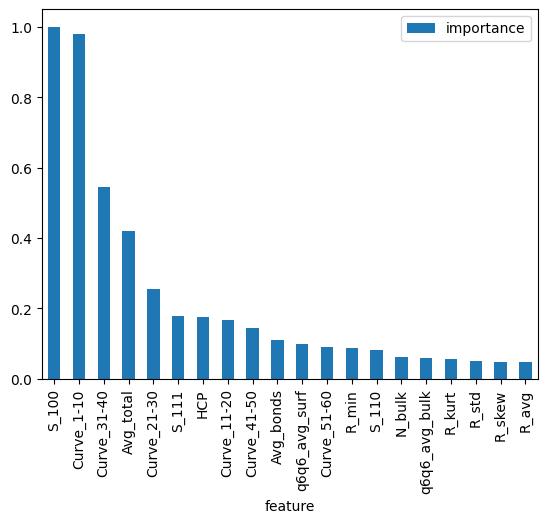

In [37]:
import numpy as np
# get mean absolue shap values from shap values
feature_importance_shap_rf = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(shap_values_rf.values).mean(0)})
feature_importance_shap_rf.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_shap_rf = feature_importance_shap_rf.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_shap_rf).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

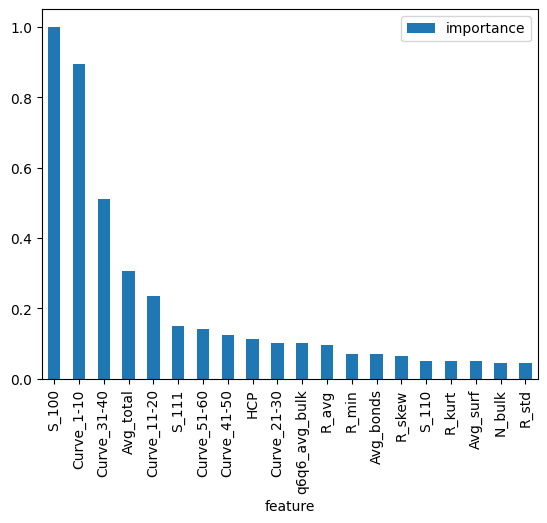

In [38]:
# get mean absolue shap values from shap values
feature_importance_shap_xgboost = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(shap_values_xgboost.values).mean(0)})
feature_importance_shap_xgboost.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_shap_xgboost = feature_importance_shap_xgboost.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_shap_xgboost).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

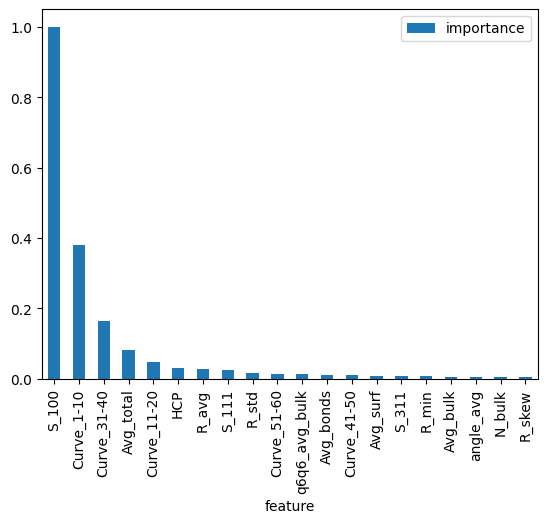

In [28]:
# get mean absolue shap values from shap values
feature_importance_perm_xgboost = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(per_xgboost.importances_mean)})
feature_importance_perm_xgboost.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_perm_xgboost = feature_importance_perm_xgboost.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_perm_xgboost).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

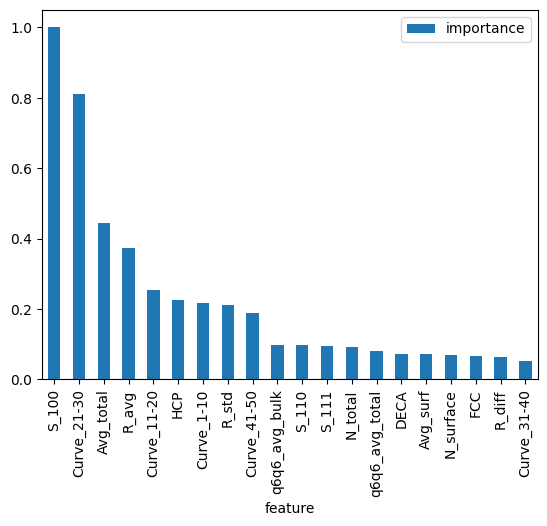

In [29]:
# get mean absolue shap values from shap values
feature_importance_perm_mlp = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(per_mlp.importances_mean)})
feature_importance_perm_mlp.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_perm_mlp = feature_importance_perm_mlp.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_perm_mlp).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

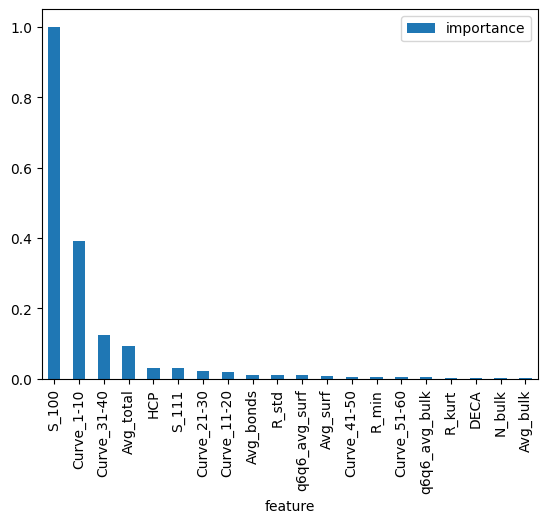

In [30]:
# get mean absolue shap values from shap values
feature_importance_perm_rf = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(per_rf.importances_mean)})
feature_importance_perm_rf.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_perm_rf = feature_importance_perm_rf.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_perm_rf).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

<Axes: xlabel='feature'>

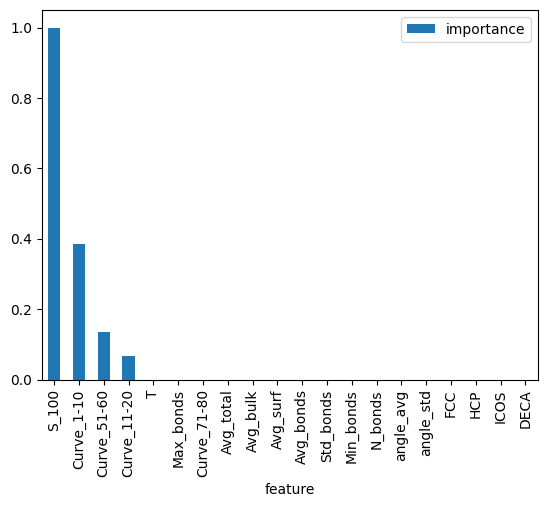

In [31]:
# get mean absolue shap values from shap values
feature_importance_surrogate_rf = pd.DataFrame({'feature': X_df.iloc[:, :-1].columns, 'importance': np.abs(surrogate_model_rf.feature_importances_)})
feature_importance_surrogate_rf.sort_values(by='importance', ascending=False)
# plot the most important 20 features based on their importance rankings
feature_importance_surrogate_rf = feature_importance_surrogate_rf.sort_values(by='importance', ascending=False)
scale_importance(feature_importance_surrogate_rf).iloc[:20,:].plot.bar(x='feature', y='importance', rot=90)

In [100]:
def plot_feature_importance_comparison(feature_importance_ranking_index, *feature_importance_ranking_lists, labels, title):
    colors_bar = ['#501da8', '#ff0d57', '#00AEEF']
    colors_curve = ['#501da8', '#ff0d57', '#00AEEF']
    # scale the importance values
    df1 = scale_importance(feature_importance_ranking_index)  # first DataFrame
    other_dfs = list(feature_importance_ranking_lists)  # other DataFrames
    # Rearrange other DataFrames based on the feature names in the first DataFrame
    for i in range(len(other_dfs)):
        other_dfs[i] = scale_importance(other_dfs[i])
        other_dfs[i] = other_dfs[i].set_index('feature')
        other_dfs[i] = other_dfs[i].reindex(index=df1['feature'])
        other_dfs[i] = other_dfs[i].reset_index()

    # Combine all DataFrames into a list
    dfs = list(other_dfs)

    # Plot feature importances
    features = df1['feature'].values
    n = len(dfs)  # number of feature importance lists
    bar_width = 0.2  # width of each bar

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 3))

    # For each DataFrame, add a set of bars to the plot
    for i, df in enumerate(dfs):
        x = np.arange(len(features)) + i * bar_width  # x-coordinates of the bars
        ax.bar(x, df['importance'], bar_width, label=labels[i], color=colors_bar[i], alpha=0.5)
        ax.plot(x, df['importance'], color=colors_curve[i], marker='o', alpha=0.8)
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.grid(axis='y', alpha=0.75)
    # Add xticks on the middle of the group bars
    plt.xlabel('Features', fontsize=12)
    plt.xticks(np.arange(len(features)) + bar_width * (n - 1) / 2, df1['feature'], rotation=90)

    plt.ylabel('Importance', fontsize=12)
    # plt.title(title, fontsize=12)
    ax.legend()

    # Show the plot
    plt.show()

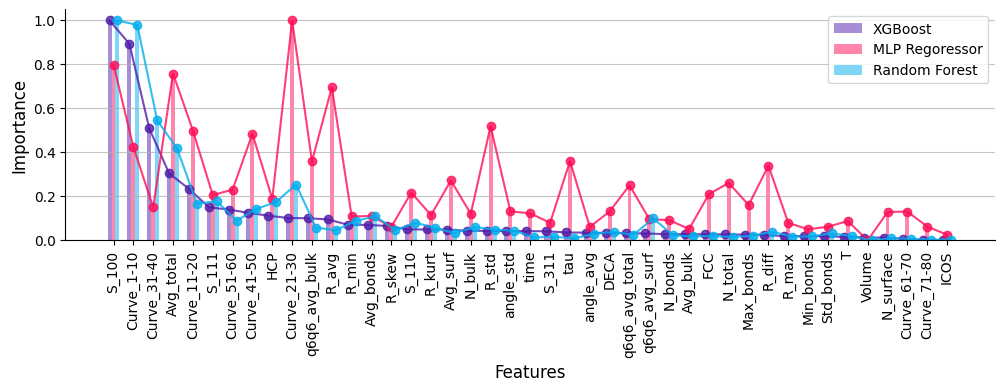

In [105]:
plot_feature_importance_comparison(feature_importance_shap_xgboost, feature_importance_shap_xgboost, feature_importance_shap_mlp, feature_importance_shap_rf, labels = ['XGBoost', 'MLP Regoressor', 'Random Forest'], title= 'Feature Importance Ranking from Equally Good Models')

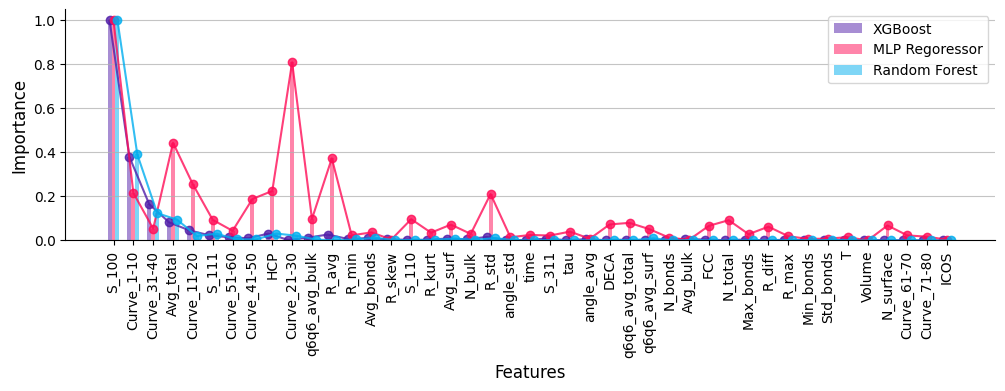

In [104]:
plot_feature_importance_comparison(feature_importance_shap_xgboost, feature_importance_perm_xgboost, feature_importance_perm_mlp, feature_importance_perm_rf, labels = ['XGBoost', 'MLP Regoressor', 'Random Forest'], title= 'Feature Importance Ranking from Equally Good Models')